In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/rupertmenneer/Documents/git/bayesian_flow/')
from discretised.bfn_discretised_data import DiscretisedBimodalData
from discretised.bfn_discretised import BayesianFlowNetworkDiscretised
from bfn.models import SimpleNeuralNetworkDiscretised
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD, AdamW
import matplotlib.pyplot as plt
import torch
torch.set_printoptions(precision=5, sci_mode=False)
k = 5
dataset = DiscretisedBimodalData(n=1000, k=k)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, drop_last=True)
batch = next(iter(dataloader))

torch.Size([256, 1])


(array([38., 76.,  8., 98., 36.]),
 array([-0.80000001, -0.48000002, -0.16000003,  0.15999997,  0.47999996,
         0.79999995]),
 <BarContainer object of 5 artists>)

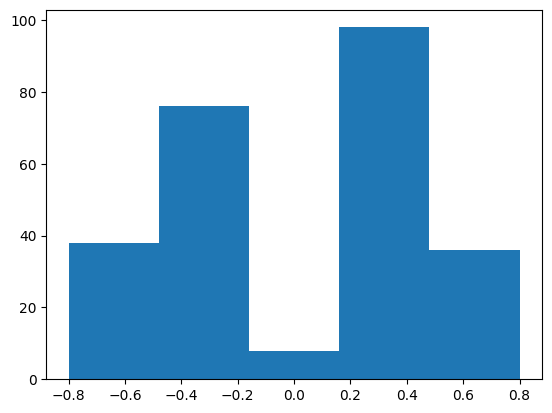

In [2]:
print(batch.shape)
plt.hist(batch.squeeze(), bins=k)

In [3]:
from torch_ema import ExponentialMovingAverage

device = 'cpu'
bfn_model = BayesianFlowNetworkDiscretised(SimpleNeuralNetworkDiscretised(), device=device, k=k).to(device)
optim = AdamW(bfn_model.parameters(), lr=3e-4, betas=(0.9, 0.98), weight_decay=0.01)

ema = ExponentialMovingAverage(bfn_model.parameters(), decay=0.995)
torch.autograd.set_detect_anomaly(True)
epochs = 5000
losses = []
n_batches_track = 100
for i in range(epochs):
    # print(i)
    epoch_losses = []
    for _, batch in enumerate(dataloader):
        optim.zero_grad()
        loss = bfn_model.continuous_time_loss_for_discretised_data(batch.to(device))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(bfn_model.parameters(), max_norm=2.0)
        optim.step()
        # Update the moving average with the new parameters from the last optimizer step
        ema.update()
        epoch_losses.append(loss.item())
    if i%n_batches_track == 0:
        print(f'Epoch {i+1}/{epochs}, Loss: {torch.mean(torch.tensor(epoch_losses))}')
    losses.append(torch.mean(torch.tensor(epoch_losses)))



Epoch 1/5000, Loss: 1.892107367515564
Epoch 101/5000, Loss: 1.489834189414978
Epoch 201/5000, Loss: 1.4602279663085938
Epoch 301/5000, Loss: 1.4214435815811157
Epoch 401/5000, Loss: 1.4868717193603516
Epoch 501/5000, Loss: 1.4514840841293335
Epoch 601/5000, Loss: 1.5783634185791016
Epoch 701/5000, Loss: 1.5074084997177124
Epoch 801/5000, Loss: 1.9252628087997437
Epoch 901/5000, Loss: 1.535125732421875
Epoch 1001/5000, Loss: 1.414299488067627
Epoch 1101/5000, Loss: 1.499619483947754
Epoch 1201/5000, Loss: 1.605081558227539
Epoch 1301/5000, Loss: 1.5942825078964233
Epoch 1401/5000, Loss: 1.2372419834136963
Epoch 1501/5000, Loss: 1.434935212135315
Epoch 1601/5000, Loss: 1.617052674293518
Epoch 1701/5000, Loss: 1.4766322374343872
Epoch 1801/5000, Loss: 1.2469083070755005
Epoch 1901/5000, Loss: 1.3593043088912964
Epoch 2001/5000, Loss: 1.2310364246368408
Epoch 2101/5000, Loss: 1.4775997400283813
Epoch 2201/5000, Loss: 1.4397011995315552
Epoch 2301/5000, Loss: 1.3982852697372437
Epoch 2401/5

Text(0.5, 1.0, 'Training loss')

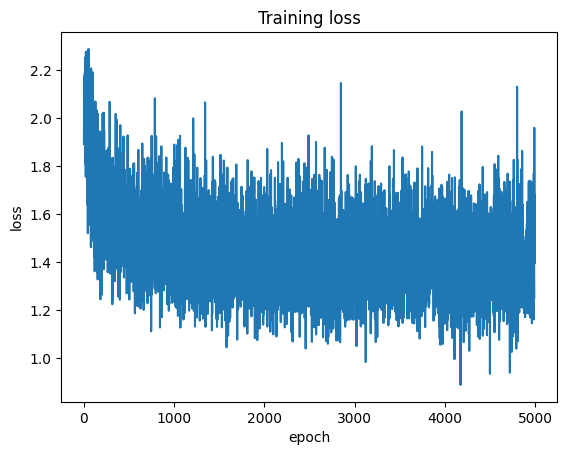

In [4]:
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training loss')

# Sample generation

In [5]:
k=5
bs=1000
dataloader = DataLoader(dataset, batch_size=bs, shuffle=True)
batch = next(iter(dataloader))
print(len(torch.unique(batch)))
samples, priors = bfn_model.sample_generation_for_discretised_data(n_steps=10, bs=bs)
samples = samples.to(torch.float32)
print(len(torch.unique(samples)))

5
5


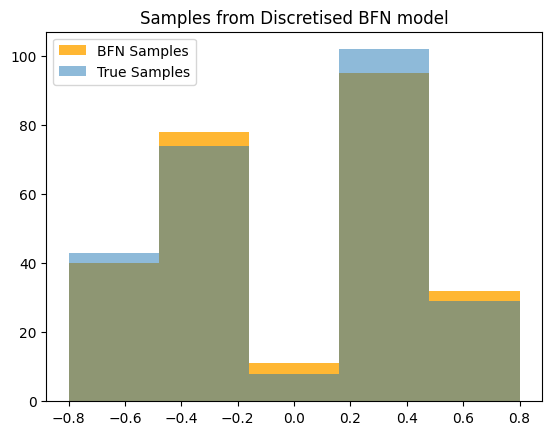

In [11]:
k=5
bs=256
dataloader = DataLoader(dataset, batch_size=bs, shuffle=True)
batch = next(iter(dataloader))
batch.shape
with ema.average_parameters():
    samples, priors = bfn_model.sample_generation_for_discretised_data(bs=bs)
    samples = samples.to(torch.float32)

plt.hist(samples.detach().numpy(), alpha=0.8, bins=k, label='BFN Samples', color='orange')
plt.hist(batch.numpy(), bins=k, alpha=0.5, label='True Samples')
plt.title('Samples from Discretised BFN model')
plt.legend()

Text(0.5, 1.0, 'Mean samples over time from Discretised BFN model')

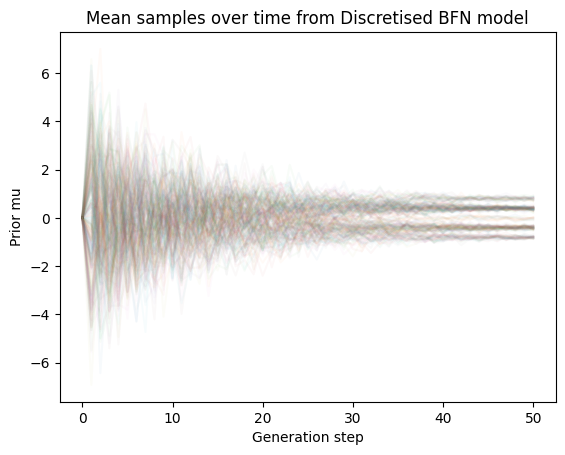

In [12]:
plt.plot(priors.detach().numpy()[:, :, 0, :].squeeze().T, label='Prior mu', alpha=0.03);
plt.xlabel('Generation step')
plt.ylabel('Prior mu')
plt.title('Mean samples over time from Discretised BFN model')